# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing libraries and data

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [5]:
# Configure API key 

quandl.ApiConfig.api_key = 'RZuPW3xd7RiK2QfuRWi-'

In [6]:
# Importing the Federal Reserve Economic Data "Real Potential Gross Domestic Product" variable.

data = quandl.get('FRED/GDPPOT')

In [7]:
data.head(5)

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [8]:
data.shape

(332, 1)

In [9]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

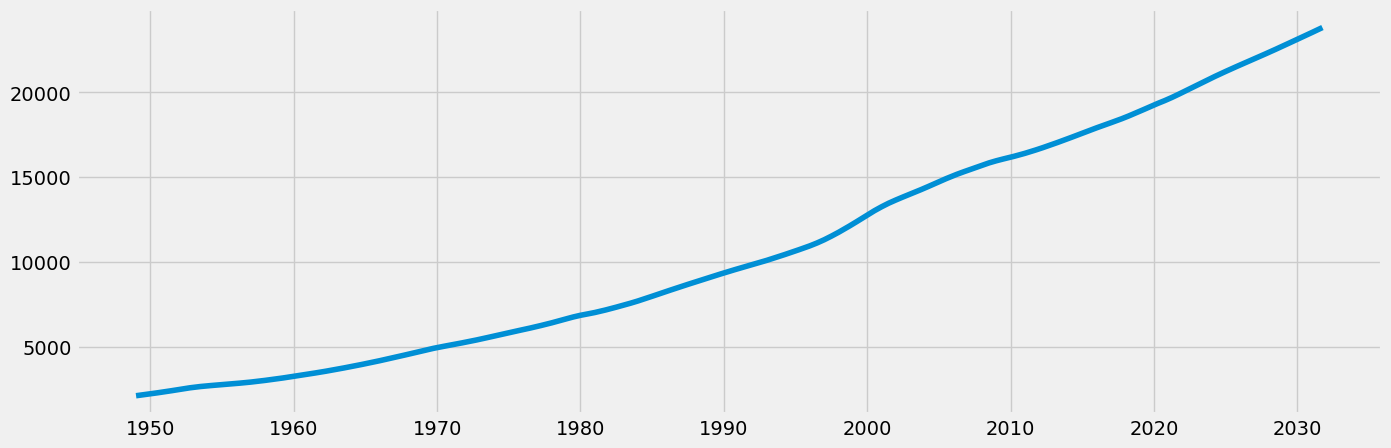

In [10]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [11]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [12]:
data_2.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


### I will subset my data to include only data from 1980 to 2022 and exclude any forecasts.

In [13]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2022-06-01')]

In [14]:
data_sub.shape

(170, 2)

In [15]:
data_sub.head()

,Date,Value
124,1980-01-01,6847.481683
125,1980-04-01,6890.146039
126,1980-07-01,6928.061362
127,1980-10-01,6968.010712
128,1981-01-01,7012.104757


In [16]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,6847.481683
1980-04-01,6890.146039
1980-07-01,6928.061362
1980-10-01,6968.010712
1981-01-01,7012.104757


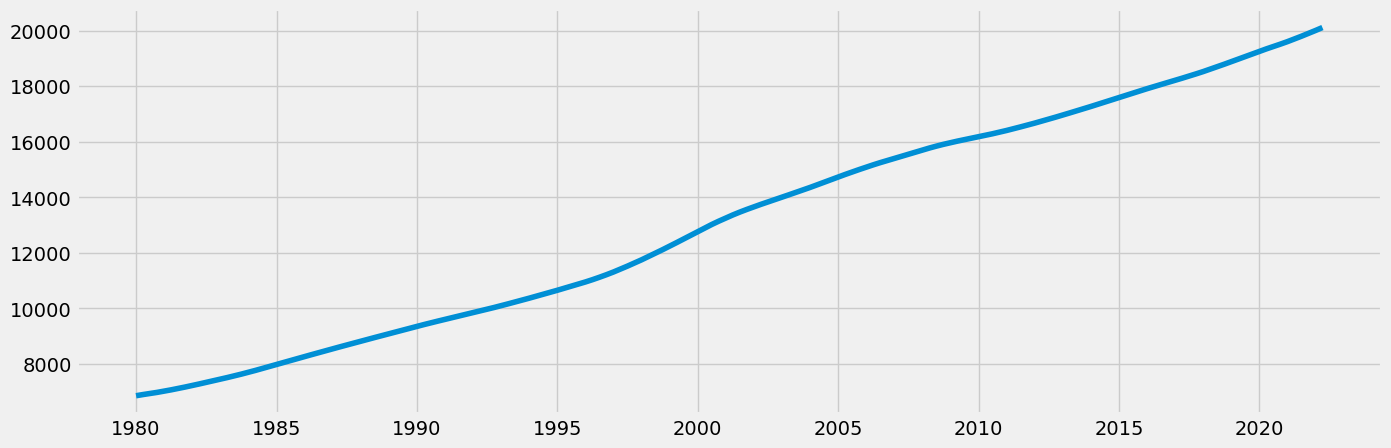

In [17]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [18]:
# Check for missing values (none)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [19]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [20]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [21]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

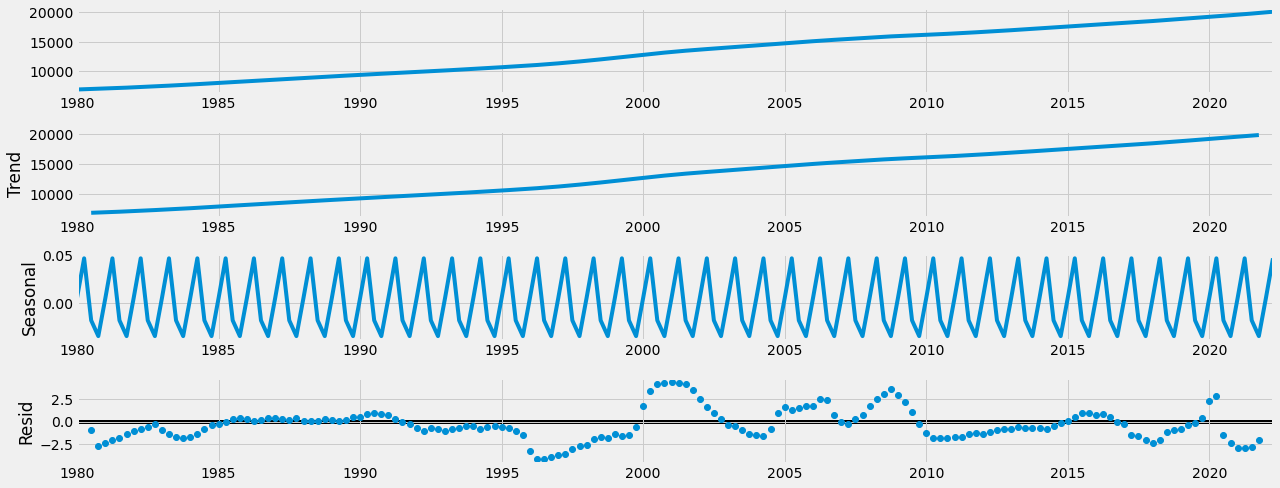

In [22]:
# Plot the separate components

decomposition.plot()
plt.show()

### Decomposing the data shows that there is an overall upward trend, as well as seasonal data and noise present, so the data is likely non-stationary. But we will test it for sure in the next section.

### 4. Testing for stationarity

In [23]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.468192
p-value                          0.983874
Number of Lags Used              2.000000
Number of Observations Used    167.000000
Critical Value (1%)             -3.470126
Critical Value (5%)             -2.879008
Critical Value (10%)            -2.576083
dtype: float64


### The results of the Dickey Fuller test show that the data is not stationary. The test statistic is larger than the critical value at 5%. This means that we cannot reject the null hypothesis, the presence of a unit root in the data.

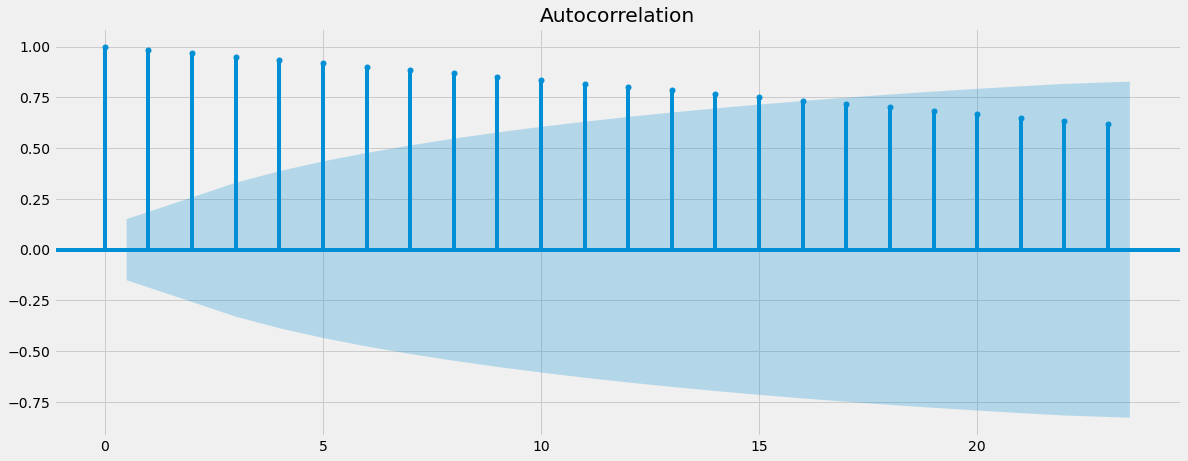

In [24]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [25]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [26]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [27]:
data_diff.head()

,Value
datetime,
1980-04-01,42.664356
1980-07-01,37.915323
1980-10-01,39.949350
1981-01-01,44.094045
1981-04-01,47.180044


In [28]:
data_diff.columns

Index(['Value'], dtype='object')

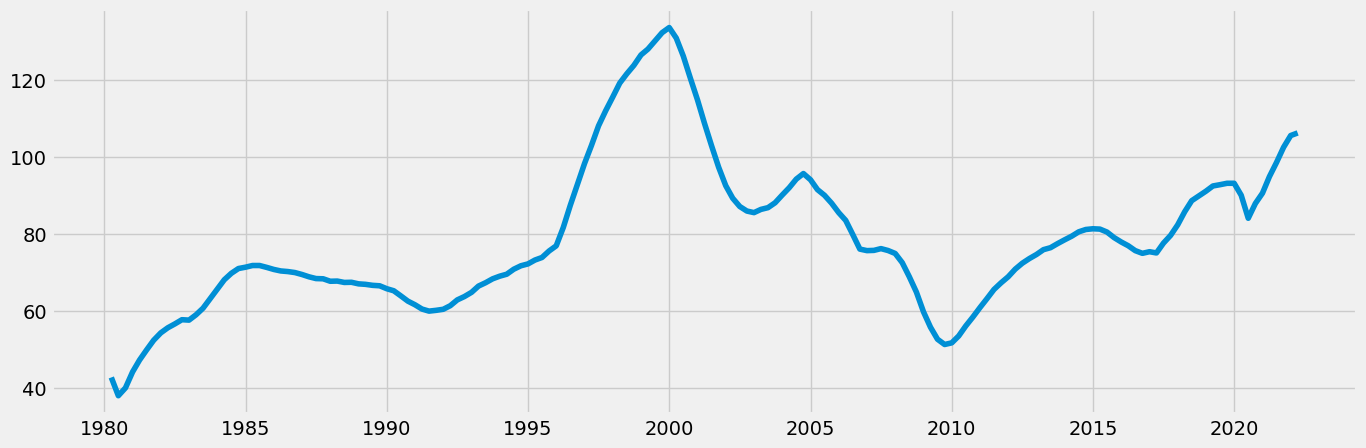

In [29]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.536788
p-value                          0.007091
Number of Lags Used              1.000000
Number of Observations Used    167.000000
Critical Value (1%)             -3.470126
Critical Value (5%)             -2.879008
Critical Value (10%)            -2.576083
dtype: float64


### After running a round of differencing, we would be able to reject the null hypothesis since the results of the Dickey Fuller test show a test statistic smaller than the critical value.

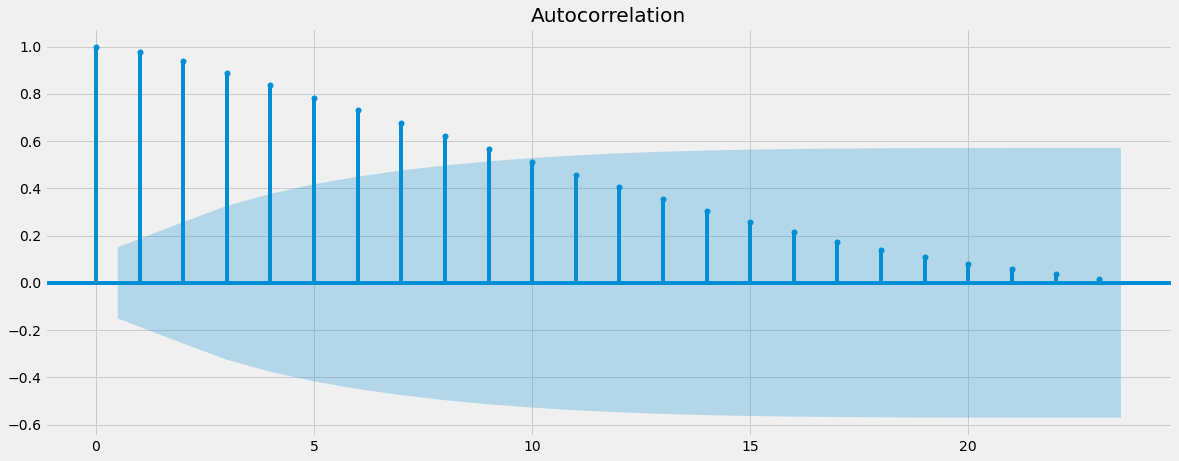

In [31]:
plot_acf(data_diff)
plt.show()